In [37]:
# Import useful things

import numpy as np      
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import rcParams
import matplotlib.dates as md

# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='8'
rcParams['ytick.major.pad']='8'

# Supress warnings for notebook ease of use
import warnings
warnings.filterwarnings("ignore")

In [2]:

def get_flux_estimations(start,stop,d_loc,avp):
    f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
    flux_out = pd.DataFrame(columns=['SHF', 'LHF', 'MOMFU', 'QC_LHF', 'QC_SHF', 'QC_MOMFU'])
    QC_out = pd.DataFrame(columns=['Dates','skew_u','skew_v','skew_w','skew_T','skew_q','kurt_u','kurt_v','kurt_w','kurt_T','kurt_q','sst_wu','sst_wv','sst_wt','sst_wq','Obukhov','BowenRatio','FrictionU','ZoverL','sigma_w','itc_w','quality_wu','quality_wv','quality_wt','quality_wq'])
    for date in f_date_list: 
        f1 = d_loc + r'Flux_estimates/Flux_estimates_%smin_%s.csv'%(avp,str(date.date()))
        f2 = d_loc + r'Flux_QC/Flux_QC_%smin_%s.csv'%(avp,str(date.date()))                      
        try:
            data = pd.read_csv(f1,parse_dates=[0],index_col=[0])
            qc_dat = pd.read_csv(f2,parse_dates=[0],index_col=[0])
        except:
            print('No data for %s'%str(date.date()))
            continue

        flux_out = flux_out.append(data,sort=True)
        QC_out = QC_out.append(qc_dat,sort=True)

    # Get rid of any duplicates
    flux_out = flux_out[~flux_out.index.duplicated()]
    QC_out = QC_out[~QC_out.index.duplicated()]

    # Crop to datetime
    flux_out=flux_out[start:stop]
    QC_out=QC_out[start:stop]
    
    return flux_out,QC_out
      
def qc_flux(flux,qc_lev):
    qcd = flux.copy()
    qcd['LHF'][flux['QC_LHF']==0]=np.nan
    qcd['SHF'][flux['QC_SHF']==0]=np.nan
    qcd['MOMFU'][flux['QC_MOMFU']==0]=np.nan
    if qc_lev==1: 
        qcd = flux.copy()
        qcd['LHF'][flux['QC_LHF']==2]=np.nan
        qcd['SHF'][flux['QC_SHF']==2]=np.nan
        qcd['MOMFU'][flux['QC_MOMFU']==2]=np.nan      
    
    return qcd

In [5]:
# Flux directory
d_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/TurbulentFluxes/'

# date range
start = dt.datetime(2019,6,1,0,0,0)
stop = dt.datetime(2019,8,7,18,0,0)

# Get flux estimates and qc data
flux_15, QC_15 = get_flux_estimations(start,stop,d_loc,15)
flux_30, QC_30 = get_flux_estimations(start,stop,d_loc,30)

# QC flux data
# level 2 gives you all the 1 and 2 flagged data
# level 1 just gives you the 1 flagged data
flux_15_qcd = qc_flux(flux_15,2)
flux_30_qcd = qc_flux(flux_30,2)

# Choose what to plot
avp=15
Hs = -flux_15_qcd['SHF']
Hl = -flux_15_qcd['LHF']

No data for 2019-08-07
No data for 2019-08-07


In [6]:
# Get radiation data. 

rad_dloc = '/Users/heather/Summit-Melt-Events/data/NOAA/radiation/smt_rad_summer2019.nc'

# Read netcdf file
# Flux units = W/m2
# albedo: albedo
# cloud visible optical depth
# turbulent sensible flux, bulk calculation: Hs
# downwelling longwave: LWdn
# upwelling longwave: LWup
# upwelling shortwave: SWup
# best estimate shortwave: BESW - Is this net shortwave?? Not sure - check. 
# surface skin temp: Tsfc

rad_nc = Dataset(rad_dloc,'r')

year = rad_nc.variables['yyyy'][:]
month = rad_nc.variables['mo'][:]
day = rad_nc.variables['day'][:]
hour = rad_nc.variables['hh'][:]
minute = rad_nc.variables['mi'][:]
sec = rad_nc.variables['ss'][:]
albedo = rad_nc.variables['albedo'][:]
Hs =  rad_nc.variables['Hs'][:]
LWdn = rad_nc.variables['LWdn'][:]
LWup = rad_nc.variables['LWup'][:]
SWup = rad_nc.variables['SWup'][:]
BESW = rad_nc.variables['BESW'][:]
Tsfc = rad_nc.variables['Tsfc'][:]
DifSW = rad_nc.variables['DifSW'][:]
DirSW = rad_nc.variables['DirSW'][:]

# Make dataframe

rad_df = pd.concat([pd.Series(year,name='year'),
                    pd.Series(month,name='month'),
                    pd.Series(day,name='day'),
                    pd.Series(hour,name='hour'),
                    pd.Series(minute,name='minute'),                   
                    pd.Series(sec,name='second'),                   
                    pd.Series(albedo,name='albedo'),                  
                    pd.Series(Hs,name='Hs'),                  
                    pd.Series(LWdn,name='LWdn'),                  
                    pd.Series(LWup,name='LWup'),                  
                    pd.Series(SWup,name='SWup'),                  
                    pd.Series(BESW,name='BESW'),                  
                    pd.Series(Tsfc,name='Tsfc'),                  
                    pd.Series(DifSW,name='DifSW'),                  
                    pd.Series(DirSW,name='DirSW')],                  
                   axis=1)

rad_df['Date'] = pd.to_datetime(rad_df.iloc[:,0:6])
rad_df = rad_df.set_index('Date')

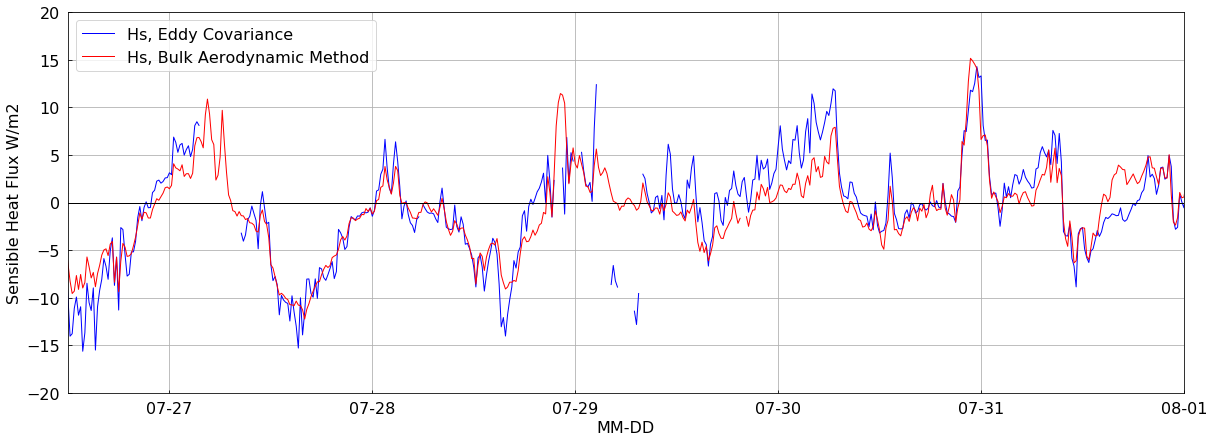

In [39]:
# Plot comparison of bulk Hs with SHF
Hs = -flux_15_qcd['SHF']
# Resample rad time series onto 15 minute intervals
Hs_rad = -rad_df['Hs'].resample(rule = '%smin'%avp, how='mean')
myFmt = md.DateFormatter('%m-%d')
rule = md.DayLocator(interval=1)

fig = plt.figure(figsize=(20,7))
ax1= fig.add_subplot(111)

ax1.plot(Hs.index,Hs,color='blue',label='Hs, Eddy Covariance',lw=1)
ax1.plot(Hs_rad.index,Hs_rad,color='red',label='Hs, Bulk Aerodynamic Method',lw=1)

ax1.axhline(0,lw=1,c='k')

ax1.set_ylim(-20,20)
#ax1.set_xlim(start,stop)
ax1.set_xlim(dt.datetime(2019,7,26,12,0),dt.datetime(2019,8,1,0,0))
ax1.set_ylabel('Sensible Heat Flux W/m2')
ax1.set_xlabel('MM-DD')
ax1.legend()
ax1.grid('on')

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)



Text(0, 0.5, 'bulk')

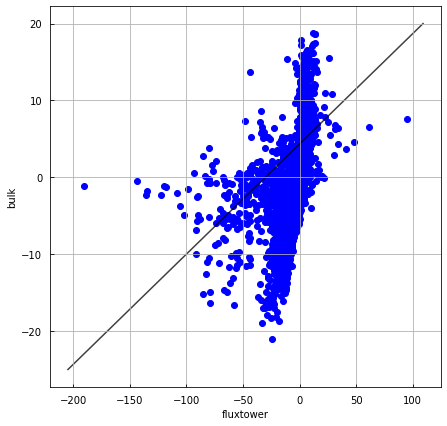

In [24]:
all_hs = pd.DataFrame({'ft':Hs,'rad':Hs_rad})
all_hs = all_hs.dropna()

fig = plt.figure(figsize=(7,7))
ax1= fig.add_subplot(111)
ax1.scatter(all_hs['ft'],all_hs['rad'],color='blue')
ax1.grid('on')
ax1_lims = [np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
        np.max([ax1.get_xlim(), ax1.get_ylim()])]  # max of both axes

ax1.plot(ax1_lims, [-25,20], 'k-', alpha=0.75, zorder=1)
ax1.set_xlabel('fluxtower')
ax1.set_ylabel('bulk')


In [23]:
ax1_lims

[-204.79777941902802, 109.16744868957147]

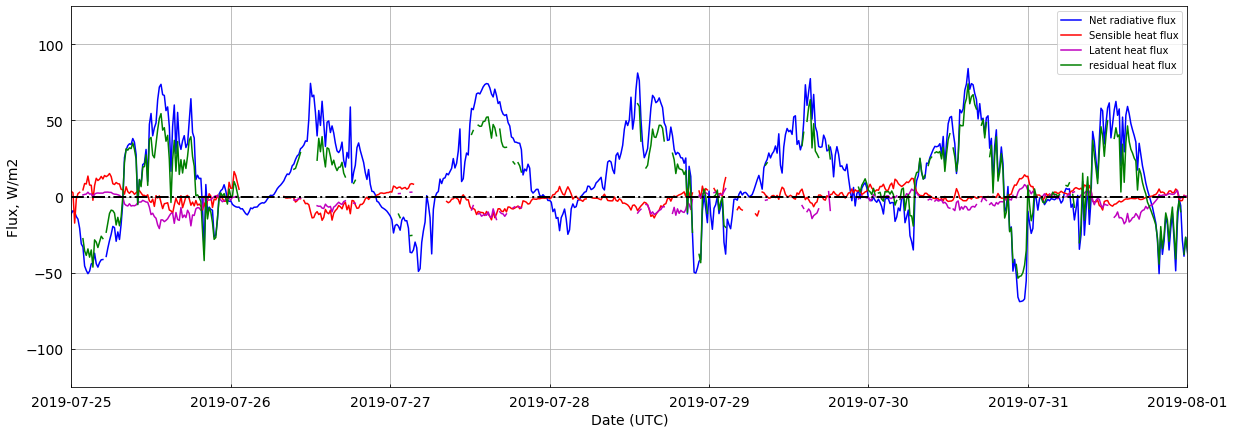

In [60]:
# Plot net radiative heat flux, shf, lhf and residual heat flux. 

# Calculate residual heat flux 
# fr = Qnet + Hs + Hl

# Qnet = (LWdn - LWup) + (SWdn - SWup)
Qnet_all = (rad_df['LWdn'] - rad_df['LWup']) + ((rad_df['DifSW'] + rad_df['DirSW']) - rad_df['SWup'])

# Subset Qnet and resample onto every 15 minutes (by mean?)
# Does it make sense to take the mean here? Or should I just the instantaneous value? 

Qnet_1min = Qnet_all.loc[start.date():stop.date()]
Qnet = Qnet_1min.resample('%s min'%avp).mean()
fr = Qnet + Hs + Hl


fig = plt.figure(figsize=(20,7))
ax1= fig.add_subplot(111)

#ax1.plot(rad_df.index,rad_df['LWdn'],c='k', label='Longwave flux (up/down)')
#ax1.plot(rad_df.index,-rad_df['LWup'],c='k')
ax1.plot(Qnet.index,Qnet,c='b', label='Net radiative flux')
ax1.plot(Hs.index,Hs,c='r', label='Sensible heat flux')
ax1.plot(Hl.index,Hl,c='m', label='Latent heat flux')
ax1.plot(fr.index,fr,c='g', label='residual heat flux')


ax1.axhline(0,lw=2,ls='-.',c='k')
ax1.set_xlim(pd.datetime(2019,7,25),pd.datetime(2019,8,1))
ax1.set_ylim(-125,125)
ax1.set_ylabel('Flux, W/m2')
ax1.set_xlabel('Date (UTC)')
ax1.legend(fontsize=10)
ax1.grid('on')

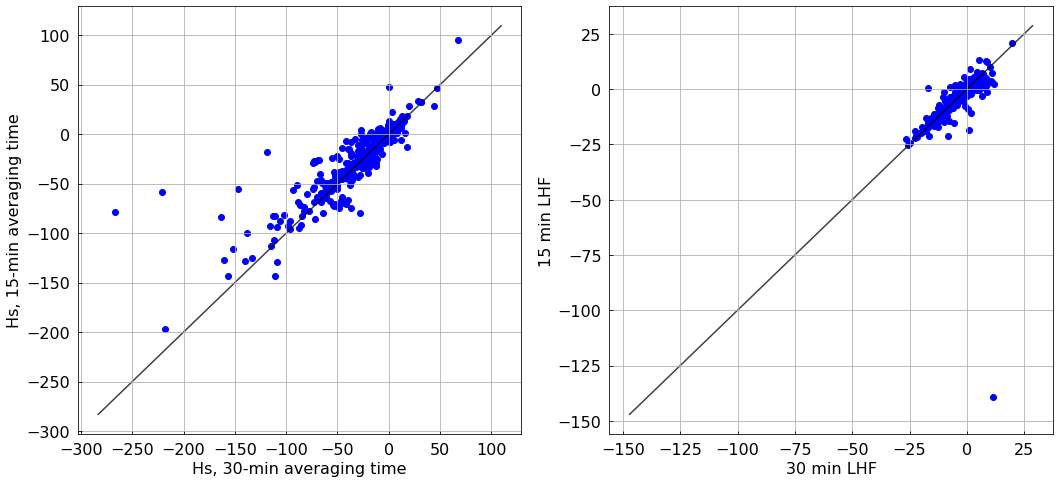

In [42]:
# Plot 30min SHF versus resampled 15 min sensible heat flux and lhf. 

resamp_SHF_15 = flux_15_qcd['SHF'].resample(rule = '30min', how='mean')
resamp_LHF_15 = flux_15_qcd['LHF'].resample(rule = '30min', how='mean')

fig = plt.figure(figsize=(15,7))
ax1= fig.add_subplot(121)
ax1.scatter(-flux_30_qcd['SHF'],-resamp_SHF_15,color='blue')
ax1.grid('on')
ax1_lims = [np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
        np.max([ax1.get_xlim(), ax1.get_ylim()])]  # max of both axes
ax1.plot(ax1_lims, ax1_lims, 'k-', alpha=0.75, zorder=1)
ax1.set_xlabel('Hs, 30-min averaging time')
ax1.set_ylabel('Hs, 15-min averaging time')

ax2= fig.add_subplot(122)
ax2.scatter(-flux_30_qcd['LHF'],-resamp_LHF_15,color='blue')
ax2.grid('on')
ax2_lims = [np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()])]  # max of both axes

ax2.plot(ax2_lims, ax2_lims, 'k-', alpha=0.75, zorder=1)
ax2.set_xlabel('30 min LHF')
ax2.set_ylabel('15 min LHF')

fig.tight_layout()